Here we are going to extract the basketball seasons from the [NBA Site](https://www.nba.com/stats/teams/traditional?Outcome=&SeasonType=Regular+Season&Season=2023-24).

1. To extract dataset from the site, we are going to use a web scraper, and chosen to go with Selenium. <br/>
   Read the docs to know more about [Selenium](https://selenium-python.readthedocs.io/installation.html)


In [3]:
# Importing all neccesary packages
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import pandas as pd
from openpyxl import Workbook, load_workbook
from buckets import dimes

In [ ]:
# Webdriver: Chrome | Site: NBA site
driver = webdriver.Chrome()
url = "https://www.nba.com/stats/teams/traditional/"
driver.get(url)

In [ ]:
# Create an Excel to begin data transfer
wb = Workbook()
wb.save('nba_stats.xlsx')
ws = wb.active
dfs = []

In [ ]:
# FIX!! SUPPOSED TO EXTRACT THE DEFINITION OF EACH COLUMN

# abbr_list = {}

# glossary_btn = Select(driver.find_element(By.CLASS_NAME, "IconButton_iconLink__Erl8y Crom_cromGlossary__ZHrZf"))
# glossary_btn.click()

# for li in list:
# abbr_list[abbr] = 

In [ ]:
# Capture all seasons in the list from web page
season_drpdwn = Select(driver.find_element(By.CLASS_NAME,"DropDown_select__4pIg9"))
seasons_arr = [sn.text for sn in season_drpdwn.options]
xpath_table = dimes.get('XPATH')

In [ ]:
# Fetch and Export Seasons' dataset into Excel
# We created multiple df requirinto insert seperate sheets in Excel. 
# Primary ('Sheet') is the junction of all df and is focused for this project,
# so we convert into CSV for its performance and simplicity

for i,sn in enumerate(seasons_arr):
    season_drpdwn.select_by_visible_text(sn)
    table = WebDriverWait(driver, 40).until(EC.visibility_of_element_located((By.XPATH, xpath_table))).get_attribute("outerHTML")
    df = pd.read_html(table)[0]
    df.dropna(how='all', axis=1, inplace=True)
    df.columns.values[0] = 'Rank'
    df.insert(2, "Season", sn)
    # print(df)
    dfs.append(df)
    with pd.ExcelWriter(path='nba_stats.xlsx', engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
       df.to_excel(writer, sheet_name= sn, index=False, header=True)

In [ ]:
# Combine all df and sorted by Win Rate
win_rate = 0.70 

full_df = pd.concat([x for x in dfs], ignore_index=True)
full_df = full_df.sort_values(by="WIN%", ascending= False).reset_index(drop=True)
full_df["Rank"] = full_df.index + 1

wol = ["W" if x >= win_rate else "L"  for x in full_df["WIN%"]]
full_df.insert(7, "W/L", wol)

# Export df 
with pd.ExcelWriter(path='nba_stats.xlsx', engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    full_df.to_excel(writer, sheet_name= 'Sheet', index=False, header=True)
    full_df.to_csv('nba_stats.csv', index=False)

In [ ]:
# Close all opened files and systems
wb.close()
driver.close()

In [4]:
# TEMPORARY (REMOVE AFTER PROJECT COMPLETION)

full_df = pd.read_csv('nba_stats.csv')

In [5]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
full_df["W/L"] = encoder.fit_transform(full_df["W/L"])

Statistics Below


In [ ]:
print(f"Size of Dataframe {full_df.shape}")
full_df

Data Cleaning. <br/>
Extract chosen columns from full df as stated in data and model report. <br/>
Normalize the numeric cols that aids in winning the tournament. <br/>


In [6]:
from sklearn.preprocessing import MinMaxScaler

num_cols = full_df.select_dtypes(include='number')
num_cols = num_cols.drop(columns='Rank')
scalar = MinMaxScaler()

norm_df = pd.DataFrame(scalar.fit_transform(num_cols), columns = num_cols.columns)
norm_df = pd.concat([full_df.drop(columns=num_cols.columns),norm_df], axis=1)

In [7]:
norm_df =norm_df.sort_values(by=['Season'])

### Exploratory Data Analysis


In [172]:
# %pip --quiet install ydata-profiling 
# from ydata_profiling import ProfileReport
# profile = ProfileReport(norm_df)

In [263]:
#Seasons and Teams list when needed
seasons = list(norm_df['Season'].sort_values().unique())
seasons_range = [seasons[0], seasons[len(seasons) - 1]]
teams = list(norm_df['Team'].unique())
print(f'All Teams played between {seasons_range[0]} and {seasons_range[1]}: {teams}')


Seasons Range: ['1996-97', '2023-24']
All Teams played between 1996-97 and 2023-24: ['Sacramento Kings', 'Washington Bullets', 'Orlando Magic', 'Los Angeles Clippers', 'Charlotte Hornets', 'Detroit Pistons', 'Philadelphia 76ers', 'Milwaukee Bucks', 'Dallas Mavericks', 'Miami Heat', 'Portland Trail Blazers', 'Toronto Raptors', 'Los Angeles Lakers', 'New York Knicks', 'San Antonio Spurs', 'Houston Rockets', 'New Jersey Nets', 'Seattle SuperSonics', 'Denver Nuggets', 'Golden State Warriors', 'Boston Celtics', 'Atlanta Hawks', 'Phoenix Suns', 'Minnesota Timberwolves', 'Vancouver Grizzlies', 'Indiana Pacers', 'Cleveland Cavaliers', 'Utah Jazz', 'Chicago Bulls', 'Washington Wizards', 'Memphis Grizzlies', 'New Orleans Hornets', 'Charlotte Bobcats', 'New Orleans/Oklahoma City Hornets', 'Oklahoma City Thunder', 'Brooklyn Nets', 'New Orleans Pelicans', 'LA Clippers']


In [242]:
# Prepare winning trend data
from plotly import express as px
from dash import dcc # likely used for group selection

win_df = norm_df[['Season','Team','WIN%']].reset_index(drop=True)
win_trend = pd.DataFrame(columns=win_df['Team'].unique(), index=win_df['Season'].unique())

for idx, row in win_df.iterrows():
    win_trend.loc[row['Season'], row['Team']] = row['WIN%']

win_trend = win_trend.reindex(sorted(win_trend.columns), axis=1) # Sorted columns names

,Atlanta Hawks,Boston Celtics,Brooklyn Nets,Charlotte Bobcats,Charlotte Hornets,Chicago Bulls,Cleveland Cavaliers,Dallas Mavericks,Denver Nuggets,Detroit Pistons,...,Phoenix Suns,Portland Trail Blazers,Sacramento Kings,San Antonio Spurs,Seattle SuperSonics,Toronto Raptors,Utah Jazz,Vancouver Grizzlies,Washington Bullets,Washington Wizards
1996-97,0.735969,0.098214,NaN,NaN,0.705357,0.9375,0.517857,0.23852,0.191327,0.705357,...,0.487245,0.627551,0.394133,0.17602,0.751276,0.331633,0.859694,0.082908,0.549745,NaN
1997-98,0.642857,0.424745,NaN,NaN,0.658163,0.829082,0.595663,0.17602,0.035714,0.440051,...,0.735969,0.580357,0.284439,0.735969,0.813776,0.11352,0.829082,0.160714,NaN,0.517857
1998-99,0.655612,0.34949,NaN,NaN,0.528061,0.196429,0.42602,0.34949,0.221939,0.604592,...,0.553571,0.757653,0.553571,0.808673,0.502551,0.451531,0.808673,0.068878,NaN,0.32398
1999-00,0.299745,0.409439,NaN,NaN,0.627551,0.128827,0.362245,0.487245,0.409439,0.517857,...,0.688776,0.783163,0.549745,0.688776,0.565051,0.565051,0.720663,0.206633,NaN,0.316327
2000-01,0.253827,0.424745,NaN,NaN,0.580357,0.098214,0.331633,0.688776,0.487245,0.362245,...,0.658163,0.642857,0.720663,0.766582,0.549745,0.595663,0.688776,0.221939,NaN,0.160714
2001-02,0.377551,0.627551,NaN,NaN,0.549745,0.191327,0.316327,0.751276,0.284439,0.642857,...,0.424745,0.627551,0.813776,0.766582,0.565051,0.517857,0.549745,NaN,NaN,0.440051
2002-03,0.409439,0.549745,NaN,NaN,NaN,0.331633,0.128827,0.798469,0.128827,0.642857,...,0.549745,0.642857,0.783163,0.798469,0.487245,0.23852,0.595663,NaN,NaN,0.440051
2003-04,0.299745,0.424745,NaN,NaN,NaN,0.221939,0.409439,0.673469,0.533163,0.705357,...,0.316327,0.502551,0.720663,0.751276,0.440051,0.377551,0.517857,NaN,NaN,0.253827
2004-05,0.067602,0.565051,NaN,0.145408,NaN,0.595663,0.517857,0.766582,0.627551,0.705357,...,0.829082,0.284439,0.642857,0.783163,0.673469,0.377551,0.269133,NaN,NaN,0.565051
2005-06,0.269133,0.377551,NaN,0.269133,NaN,0.502551,0.642857,0.798469,0.549745,0.859694,...,0.705357,0.191327,0.549745,0.844388,0.409439,0.284439,0.502551,NaN,NaN,0.517857


In [240]:
# Plotting Winning Trend
x_years = [x[:4] for x in win_trend.index] #Removing the 2 digit years, with some indicting as months

fig = px.line(win_trend, x=x_years, y=win_trend.columns,
               title= "Teams' Winning Trend",
               labels= dict(x= "Seasons", value="Win Percentage", variable="Teams")
               )

fig.update_layout(     
    xaxis = dict(
    ticktext = win_trend.index,
    tickangle = -45
    )
)

fig.update_traces(
    visible='legendonly'
)

# Need to connect gaps | Nan values gets either 0 or stemmed from intial/lastly score | Maybe create p
# Need Select button | More specifically, Select cerain regions if possible
# Edit x axis names to 'yyyy-yy' Season | currently 'yyyy' (Reference: win_trend.index)


fig.show()

In [9]:
# X = normalized_df[normalized_df["Team"] == 'Chicago Bulls'].drop(columns=['Rank', 'Team', 'W/L', 'Season'])
# X = norm_df[norm_df.columns].drop(columns=['Rank', 'Team/Season', 'WIN%'])
# featured_cols = norm_df.columns.drop(['WIN%','Rank','Team/Season'])
# featured_cols = [ 'REB', 'AST', 'STL', 'BLK']
featured_cols = ['AST']
X = norm_df[featured_cols]
y = norm_df['W/L']
# X = X.reshape(-1,1)
print(X.shape,y.shape)

(832, 1) (832,)


0.9041916167664671
(832, 1) (832,)


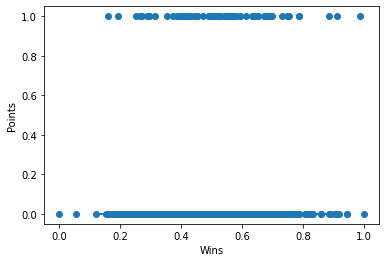

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
reg  = LogisticRegression()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

print(reg.score(X_test,y_test))
print(X.shape,y.shape)
graph_plot()